---
title: Backpropagation from scratch 
description: Backpropagation from scratch in base Python
date: 2023-10
categories: [NNs]
---

- Rederive main backprop pieces after watching Karpathy's https://www.youtube.com/watch?v=VMj-3S1tku0&ab_channel=AndrejKarpathy

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

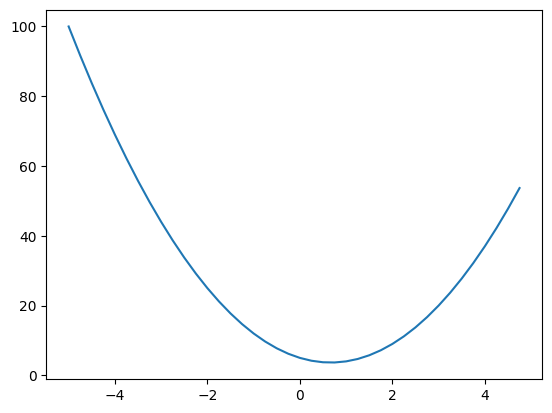

In [ ]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [ ]:
class Value:
  def __init__(self,data,_children=(),_op='',label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None # backward function does not do anything by default
    self._prev = set(_children) #set for efficiency, children in the backpropagation sense
    self._op = _op
    self.label = label
  def __repr__(self):
    return f"Value(data={self.data})"
  def __add__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data+other.data,_children=(self,other),_op='+')
    def _backward():
      self.grad += 1.0*out.grad
      other.grad += 1.0*out.grad
    out._backward = _backward
    return out
  def __mul__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data*other.data,_children=(self,other),_op='*')
    def _backward():
      # self.grad += other.grad*out.grad #HAD A BUG HERE COULD NOT PROPAGATE GRAD; FIXED BY INVESTIGATING PIECE-BY-PIECE AS SHOULD DO IN FUTURE!
      # other.grad += self.grad*out.grad
      self.grad += other.data*out.grad
      other.grad += self.data*out.grad
    out._backward = _backward
    return out

  def __pow__(self, other):
    assert isinstance(other,(int,float))
    out = Value(self.data**other,(self,),_op=f'**{other}')
    def _backward():
      self.grad += (other*self.data**(other-1)) *out.grad
    out._backward = _backward
    return out
  def tanh(self):
    x= self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out = Value(t,_children=(self,),_op='tanh')
    def _backward():
      self.grad += (1 - t**2)*out.grad
    out._backward = _backward
    return out

  # exercise: ReLu
  def relu(self):
    out = Value( self.data if self.data >=0 else 0, _children = (self,), _op='ReLU')
    def _backward():
      if self.data>=0:
        self.grad += out.grad
      else:
        self.grad = 0
      # Karpathy summarized above as self.grad += (out.data > 0) * out.grad
    out._backward = _backward
  def exp(self):
    x= self.data
    t = Value(math.exp(2*x), _children=(self,),_op='exp')
    def _backward():
      self.grad += t*t.grad
    t._backward = _backward
    return t

  def __truediv__(self,other):
    return self*other**-1

  def backward(self):
    topo = []
    visited =set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev: # FIXED INDENTATION
          build_topo(child)
        topo.append(v) # add yourself to the list after your children get added to the list
    build_topo(self)

    self.grad = 1.0
    for v in reversed(topo): # Propagating backward
      v._backward()

  def __neg__(self):
    return -1*self

  def __sub__(self,other):
    return self + (-other)
  #Python first check if self, other in __add__ can be added (self must be Value). If cannot, will flip self and other before passing them to __radd__
  #Hence __radd__ already gets arguments in flipped order!!!
  def __radd__(self,other):
    return self+other
  def __rsub__(self,other):
      return self-other
  def __rmul__(self,other):
    return self*other

In [ ]:
a = Value(2.0,label='a')
b = Value(-3.0,label='b')
c = Value(10.0,label='c')
e=a*b; e.label = 'e'
d=e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label ='Loss'; L.grad=1.0
L.backward()

In [ ]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [ ]:
from graphviz import Digraph
# ME: Note how Andrej used a closure instead of a helper, as I might
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(),set()
  def build(v):
    if v not in edges:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})
  nodes,edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name=uid, label="{%s| data %.4f | grad %.4f}" % (n.label,n.data,n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name=uid+n._op, label=n._op)
      # and connect this node for it
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)),str(id(n2))+n2._op)
  return dot

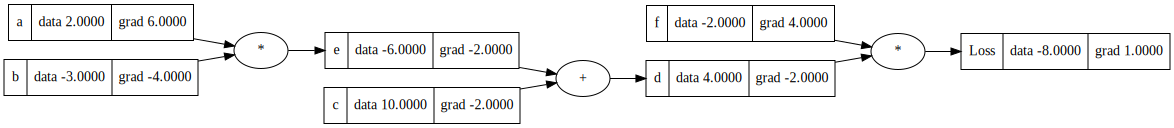

In [ ]:
draw_dot(L)

In [ ]:
L = d*f

In [ ]:
L.grad = 1.0

In [ ]:
def locally_scope():
  h=0.001
  a = Value(2.0,label='a')
  b = Value(-3.0,label='b')
  c = Value(10.0,label='c')
  e=a*b; e.label = 'e'
  d=e+c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d*f; L.label ='Loss'
  L1 = L.data

  a = Value(2.0,label='a')
  b = Value(-3.0,label='b')
  c = Value(10.0,label='c')
  e=a*b; e.label = 'e'
  d=e+c; d.label = 'd'
  f = Value(-2.0+h, label='f')
  L = d*f; L.label ='Loss'
  L2 = L.data
  print((L2-L1)/h)

locally_scope()

3.9999999999995595


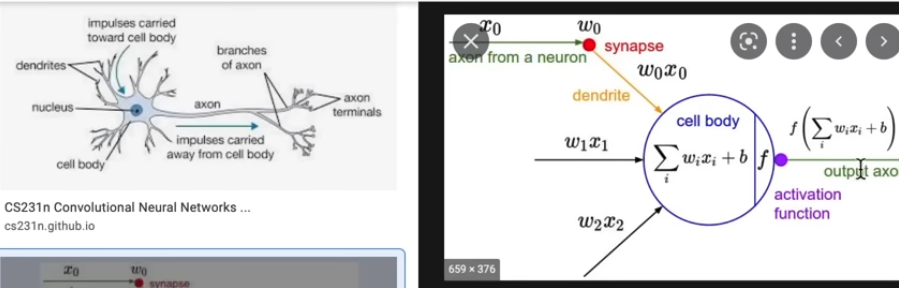

In [ ]:
import random
class Module:
  def zero_grad(self):
    for p in self.parameters():
      p.grad = 0
  def parameters(self):
    return []

class Neuron(Module):
  def __init__(self,nin): #nin: number of inputs/weights to the Neuron
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self,x):
    #w*x + b
    act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b) #sum takes second argument as start of sum, so start at self.b
    out = act.tanh()
    return out

  def parameters(self):
    return self.w +[self.b]
class Layer(Module):
  def __init__(self,nin,nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    outs = [n(x) for n in self.neurons] # call each neuron on data
    return outs[0] if len(outs) == 1 else outs
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP(Module):
  def __init__(self,nin,nouts): # a list of nouts defining the sizes of all the layers in MLP
    sz = [nin] + nouts # [3,4,4,1] in example from picture
    self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))] #sz is len(nouts) + 1!

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x) #going through and applying layer() to previous input
      #print(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()] #Notice how loops are ordered in same order as usual!!!





In [ ]:
x = [2.0, 3.0]
n = Neuron(2)
print('n(x): ', n(x))
l = Layer(2,3)
print('l(x): ', l(x))

x = [2.0, 3.0, -1.0]
m = MLP(3, [4,4,1])
print('m(x): ', m(x))

n(x):  Value(data=-0.9830138790054755)
l(x):  [Value(data=0.7705154949040606), Value(data=0.7657867069400349), Value(data=0.9990156183039722)]
m(x):  Value(data=-0.3627764910030339)


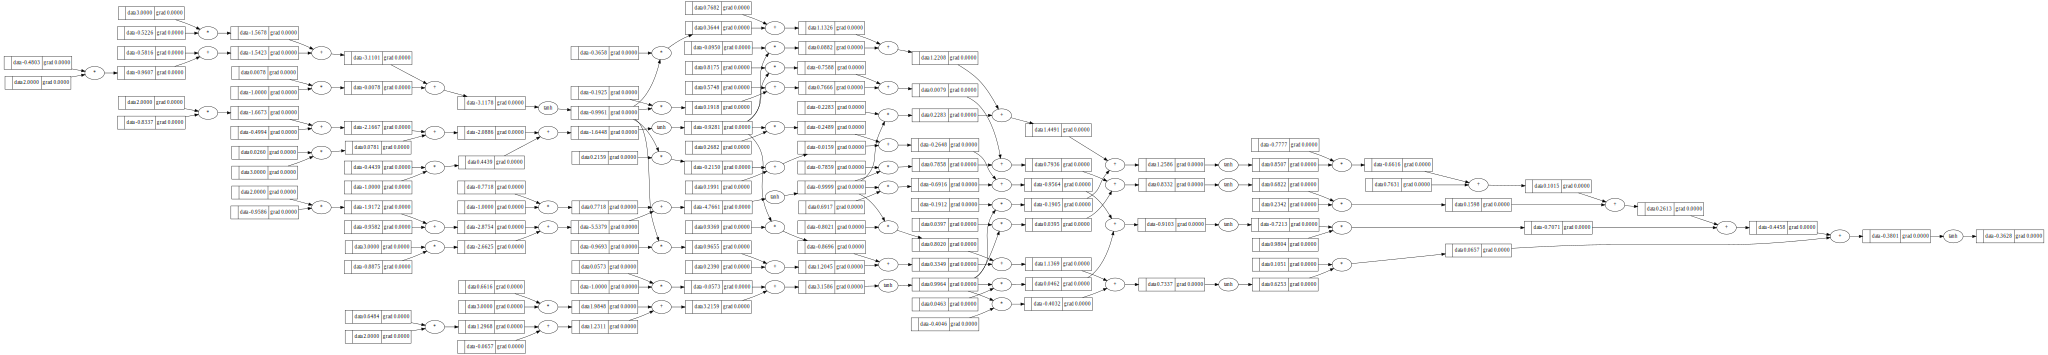

In [ ]:
draw_dot(m(x))

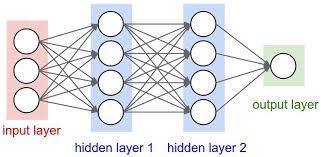

In [ ]:
xs =[
    [2.0, 3.0, -1.0],
     [3.0,-1.0,0.5],
     [0.5,1.0,1.0],
     [1.0,1.0,-1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]
ypred = [m(x) for x in xs]
ypred

[Value(data=-0.3627764910030339),
 Value(data=-0.37942407700946207),
 Value(data=-0.34471593548870183),
 Value(data=-0.2922952263934983)]

In [ ]:
#loss = sum([(yout-ygt)**2 for ygt,yout in zip(ys,ypred)])
loss = sum([(ygt-yout)**2 for ygt,yout in zip(ys,ypred)])
# ygt: y ground truth; order of subtraction important unless define __rsub__, as I did above
# deleted Layer and reran class initialization for Neuron, etc, to make this change take effect


In [ ]:
loss

Value(data=4.341698397987971)

In [ ]:
loss.grad=1.0

In [ ]:
loss.backward()

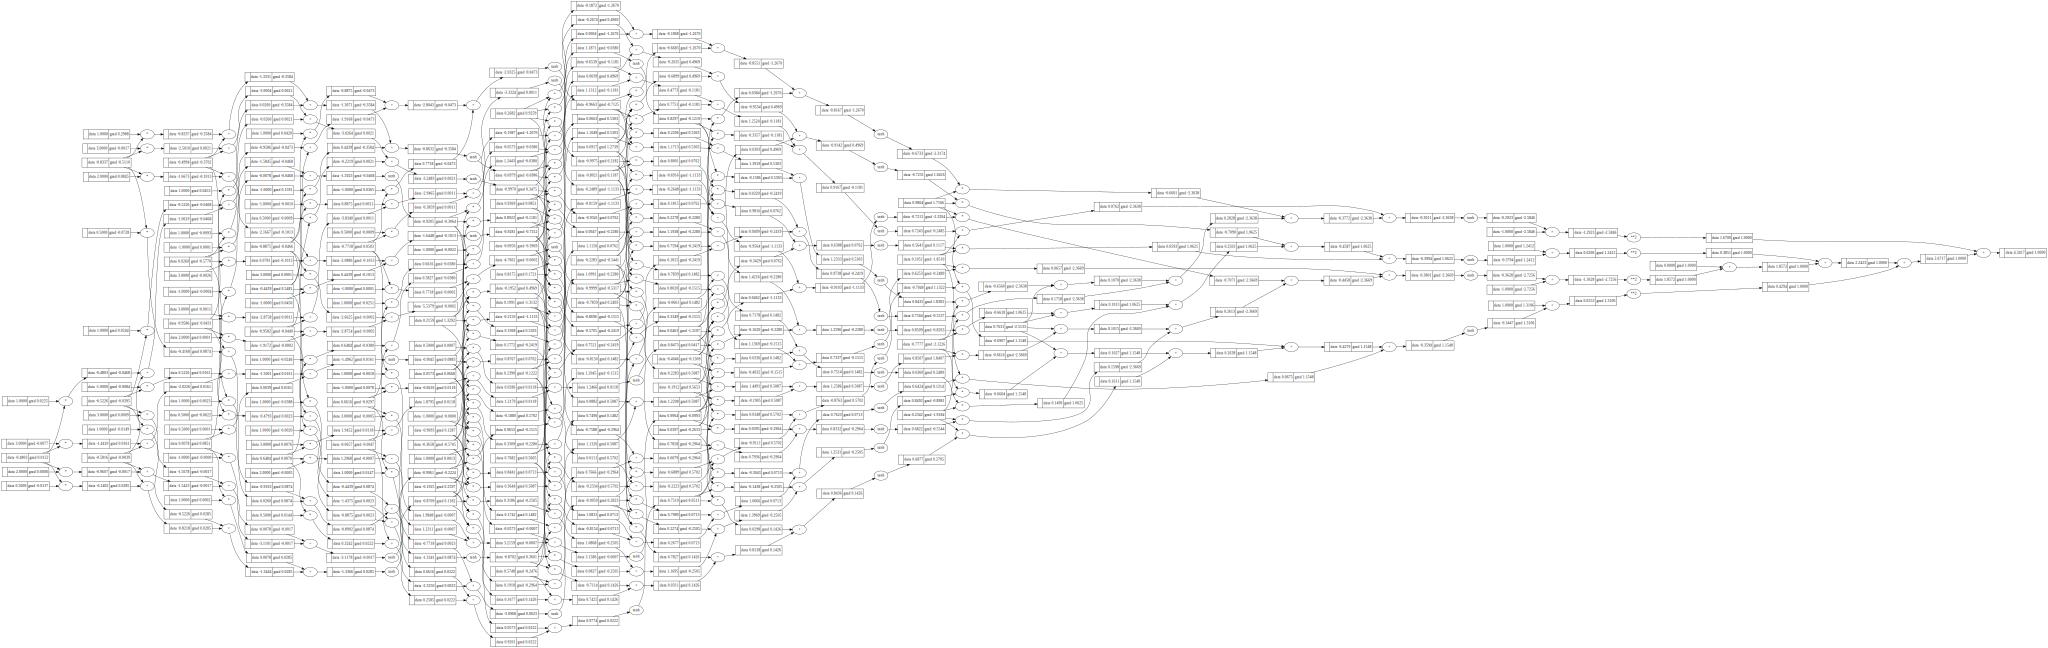

In [ ]:
draw_dot(loss)

In [ ]:
m.layers[0].neurons[0].w[0].grad

0.012225375750811174

len(m.parameters())

In [ ]:
for p in m.parameters():
  p.data += -0.01*p.grad

In [ ]:
m.layers[0].neurons[0].w[0].grad

0.012225375750811174

In [ ]:
ypred

[Value(data=-0.3627764910030339),
 Value(data=-0.37942407700946207),
 Value(data=-0.34471593548870183),
 Value(data=-0.2922952263934983)]

In [ ]:
# Building a training loop
xs =[
    [2.0, 3.0, -1.0],
     [3.0,-1.0,0.5],
     [0.5,1.0,1.0],
     [1.0,1.0,-1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]


In [ ]:

ITERS = 100
for k in range(ITERS):
  #forward pass
  ypred = [m(x) for x in xs]
  loss = sum((ygt-yout)**2 for ygt,yout in zip(ys,ypred))
  if k == 0: loss.grad = 1.0

  #backward pass
  for p in m.parameters(): # Don't double accumulate; the backward pass is taking care of accumulation with += (counteracting overwriting derivs if same variable in multiple places)
    p.grad = 0.0

  loss.backward()

  # update
  for p in m.parameters(): # m.parameters!!! Had n.parameters. FOR FUTURE, KEEP SAME NOTATION AS PRESENTER TO SAVE MY TIME!!!
    p.data += -0.05 * p.grad
  #print(k,loss.data)


#ypred

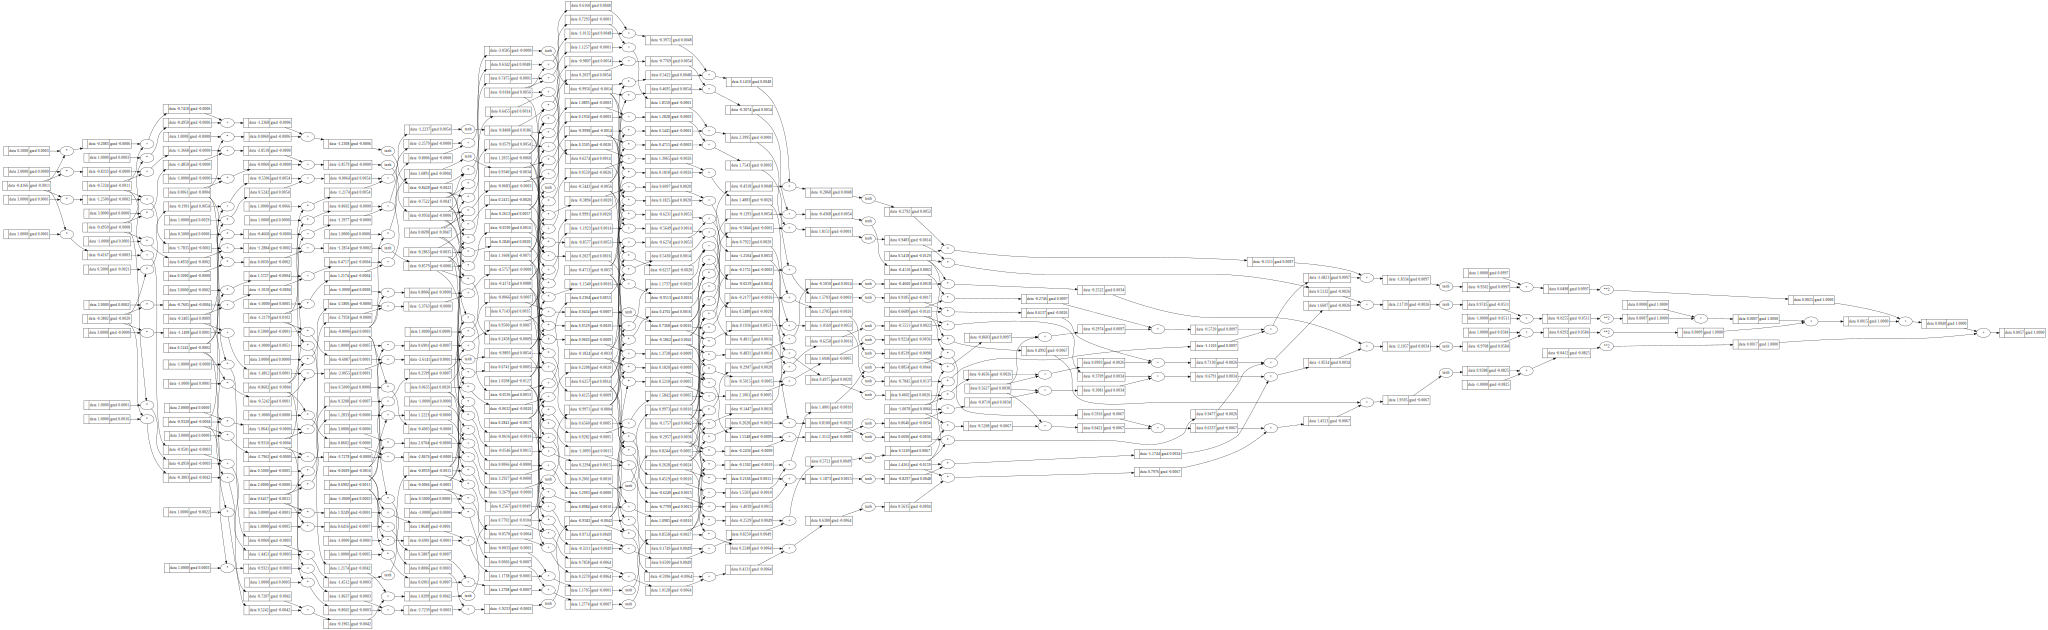

In [ ]:
draw_dot(loss)